In [72]:
import pandas as pd
from matplotlib import pyplot

In [79]:
df_target = pd.read_pickle("./dataset/TARGET-communities-extract-wellbeing.pkl")
header = df_target[0]
df_target = pd.DataFrame(data=df_target, columns=header)
df_target = df_target.drop(df_target.index[0])
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
5,万里名轩社区居委会,2,,0.0,万里街道,普陀区,121.403601417271,31.269155049366


cleanliness (1-4, 4 best), smell (0-1,1 worst),  noise (0-1, 1 worst)

In [80]:
df_target.shape

(467, 8)

467 observations and 8 features

In [82]:
df_target.dtypes

             object
clean        object
smell        object
noise        object
town         object
district     object
longitude    object
latitude     object
dtype: object

In [83]:
df_target['clean'] = pd.to_numeric(df_target['clean'])
df_target['smell'] = pd.to_numeric(df_target['smell'])
df_target['noise'] = pd.to_numeric(df_target['noise'])

In [84]:
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
5,万里名轩社区居委会,2,NaN,0.0,万里街道,普陀区,121.403601417271,31.269155049366


In [88]:
df_target.describe()

,clean,smell,noise
count,467.000000,400.000000,458.000000
mean,2.556745,0.047500,0.203057
std,0.633890,0.212972,0.402714
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000


# Data viz - See the distribution 

In [90]:
print(df_target.groupby('clean').size())
print(df_target.groupby('smell').size())
print(df_target.groupby('noise').size())

clean
1     15
2    198
3    233
4     21
dtype: int64
smell
0.0    381
1.0     19
dtype: int64
noise
0.0    365
1.0     93
dtype: int64


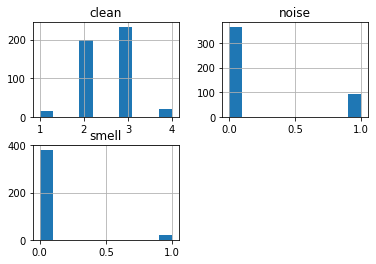

In [92]:
df_target.hist()
pyplot.show()